# 10a. Modeling Demand-Side Units and Flexibility in the ASSUME Framework

Welcome to the ASSUME DSM Workshop!

In this hands-on tutorial, we will explore how to model **Demand-Side Units (DSU)** and unlock their **flexibility potential** in electricity market simulations using the **ASSUME** framework.

---

### Why Demand-Side Flexibility in Electricity Markets?

In today’s electricity system, **Demand-Side Management (DSM)**, units help maintain physical balance and grid stability especially as more renewables increase variability and uncertainty. At the same time, in the market context, DSM enables consumers to respond to price signals, actively manage their costs, and help prevent price spikes caused by scarcity or inflexibility.

**Demand-side flexibility** enables:
- **Dynamic adaptation to price signals:** Units can increase or decrease consumption when electricity prices change, helping to flatten peaks and fill valleys in demand.
- **Grid congestion management:** DSM can be activated as a targeted resource in congested network areas, helping system operators alleviate bottlenecks without costly grid reinforcements.
- **Efficient market operations:** By shifting demand in response to market conditions, DSM units can help avoid costly price spikes and reduce the need for expensive reserve generation.
- **Integration of renewables:** Flexible demand can absorb excess renewable energy when supply is high and reduce consumption when supply is tight, supporting grid stability.
- **New revenue streams for consumers:** By offering flexibility as a market product (e.g., via reserve or capacity markets), DSM units can generate additional value.

In the ASSUME framework, **DSM units are explicitly modeled to interact with market mechanisms submitting bids, responding to electricity prices, and providing upward/downward regulation.** This allows us to analyze both the *technical* and *economic* impact of flexibility in realistic market environments.


---

### What is a Demand-Side Unit (DSU) in ASSUME?

A **DSU** in ASSUME is a *demand side agent* representing an industrial plant, building, or flexible consumer, modeled with:

- **Technology composition**: (e.g., heat pumps, boilers, electrolyzers, battery storage)
- **Technical constraints**: (e.g., rated/min/max power, storage capacity, ramp rates)
- **Market participation logic**: Ability to submit bids, react to prices, and optimize their operation.

DSUs in ASSUME can act as:
- **Passive demand**: Consuming electricity as per a fixed profile.
- **Active agents**: Shaping their demand by responding to external signals, thus providing *flexibility*.

---

### What Will We Learn in This Tutorial?

We will guide you through the **step-by-step modeling and simulation** of DSUs, focusing on how *flexibility* is implemented and utilized in ASSUME. Specifically, you will:

- Understand how DSUs can be modeled and implemented in ASSUME.
- Explore various DSM unit types available in ASSUME (e.g., Building, Hydrogen Plant, Steam Plant) and their key modeling attributes.
- Apply multiple flexibility measures to DSM units, including customizing your own.
- Integrate market bidding strategies and see how agents can monetize flexibility.
- Integrate flexibility in the market.
- Simulate and analyze a real use case: *investment decision-making for a flexible industrial plant under market uncertainty.*

---

### Key Sections

- **Section 1:** Demand vs. DSM Unit in ASSUME
- **Section 2:** Overview of DSM Units in ASSUME (Building, Hydrogen Plant, Steam Plant, etc.)
- **Section 3:** Modeling a Flexible DSM Agent
- **Section 4:** Flexibility Measures: How They Work & How to Add Your Own
- **Section 5:** From Flexibility to Market Bids Connecting with Bidding Strategies
- **Section 6:** Use Case-Investment Decision for a Paper Production Plant Under Market Uncertainty

*Ready? Let’s start unlocking demand-side flexibility in ASSUME!*


#### Workshop Agenda
1. Demand Units vs. DSM Units in ASSUME
2. DSM Units in the ASSUME Framework: What, How, and Why
3. Hands-on: Building & Modeling a DSM Unit (Demo & Key Functions)
4. Why Optimization? DSM as Agent-based Optimization Units
5. Flexibility Measures in ASSUME: Overview & How to Implement
6. Adding Your Own Flexibility Measure (Live Demo)
7. Integrating Bidding Strategies
8. Use Case: Investment Decision Under Uncertainty (Expected Utility Theory)
   - Tech configs: boiler only / boiler+HP / boiler+HP+storage
   - Scenarios: Low/Med/High CO₂ price
   - Simulate, calculate expected utility, select optimal config
9. Q&A and Wrap-up


## 0. Install Assume

First we need to install Assume in this Colab. Here we just install the ASSUME core package via pip. In general the instructions for an installation can be found here: https://assume.readthedocs.io/en/latest/installation.html. All the required steps are executed here and since we are working in colab the generation of a venv is not necessary.  

In [173]:
import importlib.util

# Check whether notebook is run in google colab
IN_COLAB = importlib.util.find_spec("google.colab") is not None

if IN_COLAB:
    !pip install assume-framework
    # Colab currently has issues with pyomo version 6.8.2, causing the notebook to crash
    # Installing an older version resolves this issue. This should only be considered a temporary fix.
    !pip install pyomo==6.8.0

# Install some additional packages for plotting
!pip install plotly
!pip install cartopy
!pip install seaborn

> **Note**: After installation, **Colab may prompt you to restart the session** due to dependency changes.
> To do so, click **"Runtime" → "Restart session..."** in the menu bar, then re-run the cells above.

---

Further we would like to access the predefined scenarios in ASSUME which are stored on the git repository. Hence, we clone the repository.

## 0.1 Repository Setup

To access predefined simulation scenarios, clone the ASSUME repository (Colab only):

In [174]:
if IN_COLAB:
    !git clone https://github.com/assume-framework/assume.git assume-repo

> Local users may skip this step if input files are already available in the project directory.

---

## 0.2 Input Path Configuration

We define the path to input files depending on whether you're in Colab or working locally. This variable will be used to load configuration and scenario files throughout the tutorial.

In [175]:
colab_inputs_path = "assume-repo/examples/inputs"
local_inputs_path = "../inputs"

inputs_path = colab_inputs_path if IN_COLAB else local_inputs_path

## 0.3 Installation Check

Use the following cell to ensure the installation was successful and that essential components are available. This test ensures that the simulation engine and RL strategy base class are accessible before continuing.

In [176]:
try:
    from assume import World

    print("✅ ASSUME framework is installed and functional.")
except ImportError as e:
    print("❌ Failed to import essential components:", e)
    print(
        "Please review the installation instructions and ensure all dependencies are installed."
    )

✅ ASSUME framework is installed and functional.


Colab does not support Docker, so dashboard visualizations included in some ASSUME workflows will not be available. However, simulation runs and RL training can still be fully executed.

* In **Colab**: Training and basic plotting are supported.
* In **Local environments with Docker**: Full access, including dashboards.

Let's also import some basic libraries that we will use throughout the tutorial.

In [177]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections.abc import Callable
from assume.units.demand import Demand
from assume.common.forecasts import NaiveForecast
import pyomo as pyo
import seaborn as sns
import yaml

# Function to display DataFrame in Jupyter
from IPython.display import display
from assume import World
from assume.common.base import (
    BaseStrategy,
    MarketConfig,
    Orderbook,
    Product,
    SupportsMinMax,
)
from assume.strategies import NaiveDADSMStrategy
from assume.scenario.loader_csv import load_scenario_folder
from assume.units.dsm_load_shift import DSMFlex

## Section 1: Demand Unit vs. DSM Unit in ASSUME

### 1.1 What is an Inflexible Demand Unit?

In the ASSUME framework, the simplest agent you can create is an **inflexible demand unit**.  
This represents a consumer (such as a city, industrial site, or region) that has a **fixed demand profile** for each time step, regardless of electricity price or market conditions.

These inflexible agents are typically used to model the **“must-serve” demand** in the system—the electricity that needs to be supplied, no matter what.  
Unlike flexible DSM units, these agents cannot adjust their consumption in response to market signals or provide demand-side flexibility.

#### **Key Characteristics**
- **Profile-based:** Their demand for each time period is pre-defined and does not change during simulation.
- **No flexibility:** Cannot participate in flexibility markets (such as load shifting or reserve).
- **Use case:** Useful for setting a baseline system demand, or representing legacy/critical loads.

---

#### **Step 1: Define Inflexible Demand Agents**

First, we create the *agent meta-data* table.  
This registers each unit with attributes needed for simulation and market interaction.

In [178]:
# 1. Define meta-data for demand units
demand_units_data = {
    "name": ["demand_north", "demand_east"],
    "technology": ["inflex_demand", "inflex_demand"],
    "bidding_EOM": ["naive_eom", "naive_eom"],
    "max_power": [100000, 100000],  # Max capacity (could be MW)
    "min_power": [0, 0],
    "node": ["north", "east"],
    "unit_operator": ["eom_de", "eom_de"],
}
demand_units = pd.DataFrame(demand_units_data)

print("Demand Agent Meta-Data Table:")
display(demand_units)


Demand Agent Meta-Data Table:


,name,technology,bidding_EOM,max_power,min_power,node,unit_operator
0,demand_north,inflex_demand,naive_eom,100000,0,north,eom_de
1,demand_east,inflex_demand,naive_eom,100000,0,east,eom_de


#### **Step 2: Define the Demand Profile**

Now, create the demand time series for each agent.  
This table provides the “what” and “when” for each agent.



In [179]:
index = pd.date_range("2023-01-01", periods=16, freq="h")
demand_df = pd.DataFrame({
    "datetime": index,
    "demand_north": [10] * 16,
    "demand_east": [10] * 16,
}).set_index("datetime")

print("Inflexible Demand Profile (first 5 hours):")
display(demand_df.head())


Inflexible Demand Profile (first 5 hours):


,demand_north,demand_east
datetime,,
2023-01-01 00:00:00,10,10
2023-01-01 01:00:00,10,10
2023-01-01 02:00:00,10,10
2023-01-01 03:00:00,10,10
2023-01-01 04:00:00,10,10


#### **Step 3: Accessing Demand Profiles**

You can now access the demand for any agent and time step directly:

In [180]:
print("Demand for 'demand_north', first 5 hours:")
print(demand_df["demand_north"].head())

Demand for 'demand_north', first 5 hours:
datetime
2023-01-01 00:00:00    10
2023-01-01 01:00:00    10
2023-01-01 02:00:00    10
2023-01-01 03:00:00    10
2023-01-01 04:00:00    10
Name: demand_north, dtype: int64


> **Summary:**  
> - The *agent table* defines WHO is in the simulation and their technical/market attributes.
> - The *profile table* (demand_df) defines WHAT these agents demand, and WHEN.

**Up Next:**  
We’ll now explore how flexible DSM units are set up—showing how they add intelligence and adaptability to the simulation.

---

#### **Example: Inflexible Load Profile for a Hydrogen Plant**

Industrial-scale hydrogen plants—such as those using electrolysers—can also be modeled as inflexible demand units if they do **not** provide demand-side flexibility.  
Below, we define an inflexible hydrogen plant unit with a fixed hourly electricity demand profile.

---

In [181]:
# Inflexible Hydrogen Plant: Meta-Data
hydrogen_plant_data = {
    "name": ["plant_H2_electrolyserA"],
    "technology": ["inflex_demand"],
    "bidding_EOM": ["naive_eom"],       # Example: simple market bidding strategy
    "max_power": [5000],                # 5 MW typical electrolyser power
    "min_power": [2000],                # 2 MW technical minimum
    "node": ["industrial_zone"],
    "unit_operator": ["h2co_gmbh"],
}
hydrogen_plant = pd.DataFrame(hydrogen_plant_data)

print("Hydrogen Plant Meta-Data Table:")
display(hydrogen_plant)

Hydrogen Plant Meta-Data Table:


,name,technology,bidding_EOM,max_power,min_power,node,unit_operator
0,plant_H2_electrolyserA,inflex_demand,naive_eom,5000,2000,industrial_zone,h2co_gmbh


In [182]:
# Inflexible Hydrogen Plant Demand Profile (example: 16 hours)
index = pd.date_range("2023-01-01", periods=16, freq="h")
# Assume night operation at max, midday ramp-down, ramp-up again in evening
demand_h2 = [62.5]*16
demand_h2_df = pd.DataFrame({
    "datetime": index,
    "plant_H2_electrolyserA": demand_h2,
}).set_index("datetime")

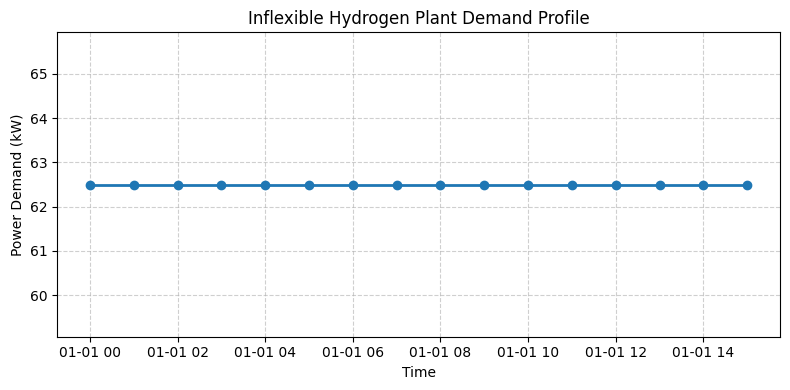

In [183]:
# Plot the hydrogen plant's inflexible load profile
plt.figure(figsize=(8, 4))
plt.plot(demand_h2_df.index, demand_h2_df["plant_H2_electrolyserA"], marker="o", color="tab:blue", linewidth=2)
plt.title("Inflexible Hydrogen Plant Demand Profile")
plt.ylabel("Power Demand (kW)")
plt.xlabel("Time")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

**Explanation:**  
- This hydrogen plant has a rigid consumption profile (e.g., dictated by process, market contract, or regulatory rules).
- It is treated as a “must-run” load: it *cannot* respond to prices or grid needs, so all electricity consumed must be provided by the market, regardless of system conditions.
- This is the reference case before introducing DSM flexibility.

---

> Next: Let’s see how to upgrade this unit to a flexible (DSM-enabled) hydrogen plant—and what that means for system operation and electricity market participation.


### 1.2 From Inflexible Demand to Flexible DSM Units

While inflexible agents simply draw power according to a schedule, **DSM units** in ASSUME are dynamic—they can optimize their consumption, react to electricity prices, and provide flexibility to the grid.

This allows for modular, reproducible modeling of large energy systems and fleets of flexible agents.


#### Key Characteristics of a Flexible DSM Unit:
- *Technology Portfolio*: Can be a combination of electrolyser, heat pump, battery, etc.
- *Operational Constraints*: Minimum/maximum power, ramp rates, storage, and more.
- *Flexibility Logic*: Allows shifting or reducing demand within operational and market rules.
- *Optimization-based Scheduling*: Uses mathematical programming to find a cost-optimal schedule, rather than following a static load curve.

In ASSUME, all demand-side units including DSM plants are configured through tabular data (Pandas DataFrames or CSVs). Each row is a unit (or a technology within a plant), with columns specifying its:
- ID, technology type, node, operator, bidding strategies, and all operational constraints.

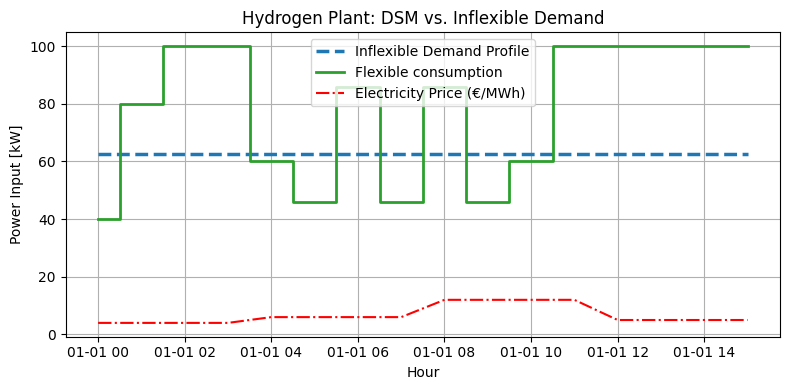

In [184]:
from assume.units.hydrogen_plant import HydrogenPlant
from assume.common.forecasts import NaiveForecast

# ---- Step 1: Set up time index and price profile ----
time_index = pd.date_range(start="2023-01-01 00:00", periods=16, freq="h")
price_signal = [40]*4 + [60]*4 + [120]*4 + [50]*4   # €/MWh

# ---- Step 2: Create NaiveForecast object with price signal ----
forecaster = NaiveForecast(
    index=time_index,
    electricity_price=price_signal,  # assign new price signal for optimization
    hydrogen_gas_price=[55]*16,      # not used here, just required by API
    H2PlantDSM_hydrogen_demand=[None]*16,  # no fixed demand (let optimizer decide)
)

# ---- Step 3: Define plant configuration (technologies) ----
components = {
    "electrolyser": {
        "max_power": 100,        # kW
        "min_power": 2,         # kW
        "ramp_up": 40,           # kW/h
        "ramp_down": 40,         # kW/h
        "efficiency": 0.8,
    },

}

# ---- Step 4: Create the HydrogenPlant DSM agent ----
hydrogen_plant = HydrogenPlant(
    id="H2PlantDSM",
    unit_operator="flex_operator",
    components=components,
    demand=1000,
    forecaster=forecaster,
    flexibility_measure="cost_based_load_shift",  # Enable optimization-based DSM
    cost_tolerance=1000,  # 10% allowed cost deviation for flexibility
    bidding_strategies={"eom": "naive_da_dsm"},
)

# ---- Step 5: Solve for optimal operation with flexibility ----
hydrogen_plant.determine_optimal_operation_with_flex()
optimized_profile = hydrogen_plant.flex_power_requirement

# ---- Step 6: Plot the results ----
plt.figure(figsize=(8, 4))

# Inflexible demand (reference profile, e.g. as a thick, dashed line)
plt.step(time_index, demand_h2, where='mid', color="tab:blue", linewidth=2.5, linestyle='--', label="Inflexible Demand Profile")

# DSM-optimized (from HydrogenPlant)
plt.step(time_index, optimized_profile, where='mid', color="tab:green", linewidth=2, label="Flexible consumption")

# Electricity price, scaled for visual clarity
plt.plot(time_index, [p/10 for p in price_signal], 'r-.', label="Electricity Price (€/MWh)")

plt.xlabel("Hour")
plt.ylabel("Power Input [kW]")
plt.title("Hydrogen Plant: DSM vs. Inflexible Demand")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



### Comparing Inflexible and Flexible Demand: The Value of DSM in Industrial Plants

The figure above illustrates a fundamental difference between the **Demand_Units** and **DSM_Units**, as implemented in ASSUME.
> In ASSUME, traditional demand units are static. By contrast, DSM agents become *active market participants*.

---


## Section 2: Overview of DSM Units in ASSUME

ASSUME provides a **modular agent-based framework** to represent all kinds of demand-side flexibility in the power system—from industrial plants to residential buildings. DSM agents in ASSUME are highly configurable and extensible, supporting a broad range of technology options, assets, and operating strategies.

---

### 2.1 Modular Structure: Industrial Plants & Buildings

ASSUME’s flexibility framework allows users to:

- **Directly create DSM agents** (industrial, building, custom) with a desired configuration of technologies.
- Populate each agent with an arbitrary combination of assets (e.g., electrolyser, furnace, heat pump, battery storage, PV, EV, thermal storage).
- Quickly add, remove, or reconfigure assets using a **component inventory**.
- Model complex process chains and interaction between technologies using the provided modular connection system.

#### Example: Modular Connections

<img src="../../docs/source/img/dsm_integration.PNG" width="600"/>

*Figure: Modular connection of technologies in an industrial plant or building agent.*

---

#### DSM Agents as Pyomo Models

Each DSM agent in ASSUME (whether it’s an industrial plant, building, or custom asset) is internally modeled as an **optimization problem using [Pyomo](http://www.pyomo.org/)**. This means:

- All physical and economic constraints (e.g., energy balances, operational limits, ramp rates, market participation rules) are represented as *explicit mathematical constraints*.
- The **objective function** (e.g., minimizing cost, maximizing profit, maximizing flexible capacity) is user-configurable and solved using state-of-the-art solvers (such as HiGHS, Gurobi, CBC).
- DSM agents dynamically optimize their operational schedule at each simulation step, responding to electricity prices, market signals, and system requirements.

This mathematical core enables **rigorous analysis of flexibility potential, operational feasibility, and market value** for any DSM technology.

---

### 2.2 DSM Agent Characteristics

ASSUME enables users to specify key **attributes and constraints** for each DSM agent, including:

- Technology/process type (e.g., electrolyser, heat pump, boiler, battery, EV, PV)
- Power and energy capacities (max/min)
- Ramping rates, efficiencies, cost parameters
- Operating strategies and flexibility measures

Each DSM agent is described by a **set of parameters**:

- **Technical attributes:**  
  - Maximum/minimum power or capacity  
  - Efficiency and ramping rates  
  - Storage duration (short-term, seasonal)  
  - Process interconnections and sequencing

- **Market behavior:**  
  - Bidding strategy (e.g., for day-ahead, balancing, CRM, redispatch markets)  
  - Flexibility measure (e.g., load shifting, price response, CRM block bidding)

- **Flexibility configuration:**  
  - Cost tolerance (how much extra cost is allowed for providing flexibility)  
  - Participation constraints (e.g., minimum bid size, symmetry, reserve duration)


These characteristics are reflected in the data tables and configuration files used to build the agents.

#### Example: Agent Attributes

<img src="../../docs/source/img/Demand_Attribute.png" width="400"/>

*Figure: Examples of demand agent characteristics and configurable attributes in ASSUME.*

---

### 2.3 Technology Inventory & Asset Library

ASSUME provides an inventory of pre-built **technology modules** in `dst_components`:

- **Industrial plants** can be configured with multiple process assets, short/long-term storage, and auxiliary systems.
- **Buildings** can combine heat pumps, boilers, thermal storage, PV, batteries, and electric vehicles (unidirectional or bidirectional).

This modular approach means you can quickly create a new agent type or expand an existing one by adding more technologies.

#### Example: Technology Options

<img src="../../docs/source/img/Industry.png" width="550"/>
<img src="../../docs/source/img/Building.png" width="550"/>

*Figure: Example technology options for industrial and building DSM agents.*

---

### 2.4 Extending the Framework

The modular DSM agent class in ASSUME makes it easy to **extend**:

- **Add new technologies** to the asset library (`dst_components`) with custom parameters.
- **Develop new agent types** by subclassing the base agent and specifying new process chains.
- **Connect additional flexibility products** (e.g., for different market participation) by adding attributes or strategy modules.

#### Example: Building Configuration File Snippet

```python
# Snippet: Defining a building agent with PV, battery, EV, and heat pump

components = {
    "pv_plant": {"max_power": 10, "efficiency": 0.98},
    "battery_storage": {"max_capacity": 40, "max_power_charge": 5, "max_power_discharge": 5, "efficiency": 0.9},
    "heat_pump": {"max_power": 8, "min_power": 2, "efficiency": 3.5},
    "electric_vehicle": {"max_power_charge": 7, "max_power_discharge": 7, "battery_capacity": 50},
}
building = Building(
    id="B102",
    unit_operator="res_operator",
    components=components,
    is_prosumer="Yes",
    flexibility_measure="cost_based_load_shift",
)


## Section 3: Creating a Custom Flexible DSM Agent in ASSUME

ASSUME is designed for modularity: you can easily define your own agent class—industrial or building—by assembling any set of technologies from the component library (`dst_components`).

Below, we show how to create a minimal custom agent by:
- Assigning key technical attributes
- Integrating any two technology blocks
- Specifying their connection (process logic)
- Exposing a flexible structure for your own processes

All DSM agents in ASSUME are ultimately **Pyomo models**: you only need to describe the structure; ASSUME handles the optimization logic!


#### 3.1 Creating a Steel Plant as a Demand-Side Agent

The industrial agent consists of several key components (e.g., furnace, heating unit, storage unit, grinding unit, etc.). These components consume electricity and can be modeled to react dynamically to market conditions.

In the ASSUME framework, a DSM agent is created by defining its characteristics, components, and objectives. Let's start by defining the core characteristics of the agent: 

In [185]:
# SPDX-FileCopyrightText: ASSUME Developers
#
# SPDX-License-Identifier: AGPL-3.0-or-later

import logging
from datetime import datetime

import pyomo.environ as pyo

from assume.common.base import SupportsMinMax
from assume.common.forecasts import Forecaster
from assume.units.dsm_load_shift import DSMFlex

logger = logging.getLogger(__name__)


class CustonIndustrialPlant(DSMFlex, SupportsMinMax):
    """
    Represents a paper and pulp plant in an energy system. This includes components like heat pumps,
    boilers, and storage units for operational optimization.

    Args:
        id (str): Unique identifier for the plant.
        unit_operator (str): The operator responsible for the plant.
        bidding_strategies (dict): A dictionary of bidding strategies that define how the plant participates in energy markets.
        forecaster (Forecaster): A forecaster used to get key variables such as fuel or electricity prices.
        components (dict, optional): A dictionary describing the components of the plant, such as heat pumps and boilers.
        objective (str, optional): The objective function of the plant, typically to minimize variable costs. Default is "min_variable_cost".
        flexibility_measure (str, optional): The flexibility measure used for the plant, such as "max_load_shift". Default is "max_load_shift".
        demand (float, optional): The production demand, representing how much product needs to be produced. Default is 0.
        cost_tolerance (float, optional): The maximum allowable increase in cost when shifting load. Default is 10.
        node (str, optional): The node location where the plant is connected within the energy network. Default is "node0".
        location (tuple[float, float], optional): The geographical coordinates (latitude, longitude) of the paper and pulp plant. Default is (0.0, 0.0).
        **kwargs: Additional keyword arguments to support more specific configurations or parameters.
    """

    required_technologies = []
    optional_technologies = [] # "heat_pump", "boiler", "thermal_storage"

    def __init__(
        self,
        id: str,
        unit_operator: str,
        bidding_strategies: dict,
        forecaster: Forecaster,
        components: dict[str, dict] = None,
        technology: str = "",
        objective: str = "",
        flexibility_measure: str = "",
        demand: float = 0,
        cost_tolerance: float = 10,
        congestion_threshold: float = 0,
        node: str = "node0",
        location: tuple[float, float] = (0.0, 0.0),
        **kwargs,
    ):
        super().__init__(
            id=id,
            unit_operator=unit_operator,
            technology=technology,
            components=components,
            bidding_strategies=bidding_strategies,
            forecaster=forecaster,
            node=node,
            location=location,
            **kwargs,
        )

        

**Bringing `dst_components` into the Plant Process**

In the plant, we use components like the **electrolyser** and **hydrogen storage** to model the production and storage of hydrogen. These components are imported from `dst_components.py` and integrated into the plant's process.

In this section, we will showcase how to model these components, define their characteristics, and integrate them into the overall process of the steel plant.

#### 3.2 Modeling Component units/technologies in the ASSUME Framework

In the **ASSUME** framework, components like the **electrolyser** and **hydrogen storage** are modeled using Pyomo, a Python-based optimization modeling tool. The framework supports detailed modeling of each component by specifying their characteristics and operational constraints.

For each component, attributes such as **rated power**, **ramp rates**, **efficiency**, etc. are defined. These attributes are essential for simulating the component's behavior in the energy system.

**Example: Electrolyser Model**
The **electrolyser** is a crucial component in hydrogen production. In this framework, the electrolyser is modeled with various characteristics, including power limits, operational efficiency, and ramp rates. These attributes ensure that the electrolyser operates within its technical and economic boundaries.

Below is a demo of the technology:


In [186]:
class Electrolyser:
  
    def __init__(
        self,
        max_power: float,
        efficiency: float,
        time_steps: list[int],
        min_power: float = 0.0,
        ramp_up: float | None = None,
        ramp_down: float | None = None,
        min_operating_steps: int = 1,
        min_down_steps: int = 1,
        initial_operational_status: int = 1,
        **kwargs,
    ):
        super().__init__()

        self.max_power = max_power
        self.efficiency = efficiency
        self.time_steps = time_steps
        self.min_power = min_power
        self.ramp_up = max_power if ramp_up is None else ramp_up
        self.ramp_down = max_power if ramp_down is None else ramp_down
        self.min_operating_steps = min_operating_steps
        self.min_down_steps = min_down_steps
        self.initial_operational_status = initial_operational_status
        self.kwargs = kwargs

    def add_to_model(
        self, model: pyo.ConcreteModel, model_block: pyo.Block
    ) -> pyo.Block:
        
        # Define parameters
        model_block.max_power = pyo.Param(initialize=self.max_power)
        model_block.efficiency = pyo.Param(initialize=self.efficiency)
        model_block.min_power = pyo.Param(initialize=self.min_power)
        model_block.ramp_up = pyo.Param(initialize=self.ramp_up)
        model_block.ramp_down = pyo.Param(initialize=self.ramp_down)
        model_block.min_operating_steps = pyo.Param(initialize=self.min_operating_steps)
        model_block.min_down_steps = pyo.Param(initialize=self.min_down_steps)
        model_block.initial_operational_status = pyo.Param(
            initialize=self.initial_operational_status
        )

        # Define variables
        model_block.power_in = pyo.Var(
            self.time_steps, within=pyo.NonNegativeReals, bounds=(0, self.max_power)
        )
        model_block.hydrogen_out = pyo.Var(self.time_steps, within=pyo.NonNegativeReals)
        model_block.operating_cost = pyo.Var(
            self.time_steps, within=pyo.NonNegativeReals
        )

        # Efficiency constraint
        @model_block.Constraint(self.time_steps)
        def hydrogen_production_constraint_rule(b, t):
            return b.hydrogen_out[t] == b.power_in[t] * b.efficiency

        # Operating cost constraint
        @model_block.Constraint(self.time_steps)
        def operating_cost_constraint_rule(b, t):
            return b.operating_cost[t] == b.power_in[t] * model.electricity_price[t]

#### 3.3 Initializing the Process Sequence for the Steel Plant

The `initialize_process_sequence()` function is responsible for defining how the different components of the DSM unit are connected to form a complete process. This function is the placeholder to model the process.

In [187]:
def initialize_process_sequence(self):
    # Per-time-step constraint (default)
    if not self.demand or self.demand == 0:

        @self.model.Constraint(self.model.time_steps)
        def direct_heat_balance(m, t):
            total_heat_production = 0
            if self.has_heatpump:
                total_heat_production += m.dsm_blocks[""].heat_out[t]
            if self.has_boiler:
                total_heat_production += m.dsm_blocks[""].heat_out[t]
            if self.has_thermal_storage:
                storage_discharge = m.dsm_blocks[""].discharge[t]
                storage_charge = m.dsm_blocks[""].charge[t]
                return (
                    total_heat_production + storage_discharge - storage_charge
                    >= m.thermal_demand[t]
                )
            else:
                return total_heat_production >= m.thermal_demand[t]

    def define_constraints(self):
        """
        Defines the constraints for the paper and pulp plant model.
        """

#### 3.4 Marginal cost/profit

In [188]:
def calculate_marginal_cost(self, start: datetime, power: float) -> float:
    """
    Calculate the marginal cost of the unit based on the provided time and power.

    Args:
        start (datetime): The start time of the dispatch
        power (float): The power output of the unit

    Returns:
        float: The marginal cost of the unit
    """
    marginal_cost = 0

    if self.opt_power_requirement.at[start] > 0:
        marginal_cost = (
            self.variable_cost_series.at[start]
            / self.opt_power_requirement.at[start]
        )

    return marginal_cost

## 4 Flexibility Measures: How They Work & How to Add Your Own

In the **ASSUME** framework, **Demand-Side Flexibility** allows agents, to adjust their energy consumption in response to external signals. This flexibility is achieved by shifting loads or adjusting operations based on the agent's predefined flexibility strategies.

In **ASSUME** we have 5 Flexibility Measures:
- **electricity_price_signal**: Reacts on the price signal
- **cost_based_load_shift**: Maximum flexibility potetial based on the risk tolerance.
- **congestion_management_flexibility**: Reacts on the grid signal.
- **symmetric_flexible_block**: Symmetric flexible blocks.
- **peak_load_shifting**: Peak clipping parameterised by the degree of curtailment
- **renewable_utilisation**: Load follows the renewable production.

In [189]:
class DSMFlex:
    # Mapping of flexibility measures to their respective functions
    flexibility_map: dict[str, Callable[[pyo.ConcreteModel], None]] = {
        "electricity_price_signal": lambda self, model: self.electricity_price_signal(
            model
        ),
        "cost_based_load_shift": lambda self, model: self.cost_based_flexibility(model),
        "congestion_management_flexibility": lambda self,
        model: self.grid_congestion_management(model),
        "symmetric_flexible_block": lambda self, model: self.symmetric_flexible_block(
            model
        ),
        "peak_load_shifting": lambda self, model: self.peak_load_shifting_flexibility(
            model
        ),
        "renewable_utilisation": lambda self, model: self.renewable_utilisation(
            model,
        ),
    }

    def design_your_own_flex_measure(self, model):
        """
        Placeholder for custom flexibility measures.
        This method can be overridden to implement specific flexibility strategies.
        """
        pass

In [190]:
# Create time index and a flat price/demand profile for simplicity
time_index = pd.date_range("2023-01-01", periods=24, freq="h")
price_EOM = [60] * 24
hydrogen_demand = [400 / 24.0] * 24  # Uniform, matches total demand of 400
# Step 1: Prepare flexible price signal (must match time_index length)
flexible_price_signal = [35]*4 + [65]*4 + [110]*4 + [45]*4

# Create the forecast object (ASSUME needs this structure)
forecast = NaiveForecast(
    time_index,
    price_EOM=price_EOM,
    hydrogen_demand=hydrogen_demand
)


In [191]:
components = {
    "electrolyser": {
        "max_power": 100,
        "min_power": 0,
        "ramp_up": 100,
        "ramp_down": 100,
        "efficiency": 1,
        "min_operating_time": 0,
        "min_down_time": 0,
    },
}


In [192]:
# Patch the class to inject attribute before __init__ runs
class MyHydrogenPlant(HydrogenPlant):
    def __init__(self, *args, electricity_price_flex=None, **kwargs):
        self.electricity_price_flex = electricity_price_flex
        super().__init__(*args, **kwargs)

In [193]:
plant = MyHydrogenPlant(
    id="tutorial_h2plant",
    unit_operator="demo_operator",
    objective="min_variable_cost",
    flexibility_measure="electricity_price_signal",
    cost_tolerance=50,
    bidding_strategies={"EOM": NaiveDADSMStrategy()},
    components=components,
    forecaster=forecast,
    demand=400,
    electricity_price_flex=flexible_price_signal,   # <-- passed early
)


In [194]:
# Reference (inflexible) operation
# plant.determine_optimal_operation_without_flex()
# inflex_profile = plant.opt_power_requirement  # FastSeries

# Flexible operation
# Assign a new flexible price series
plant.determine_optimal_operation_with_flex()

flex_profile = plant.flex_power_requirement  # FastSeries

plt.figure(figsize=(10, 4))
# plt.step(time_index, inflex_profile, where="mid", label="Inflexible Profile", linestyle="--", color="tab:blue")
plt.step(time_index, flex_profile, where="mid", label="Flexible Profile", color="tab:green")
plt.xlabel("Hour")
plt.ylabel("Power Input [kW]")
plt.title("ASSUME DSM Hydrogen Plant: Inflexible vs Flexible Operation")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


AttributeError: 'ConcreteModel' object has no attribute 'load_shift_pos'